In [9]:
#commented unecessary print statements
#defined functions in order to use numba pre compiler
#coverted some unecessary matrices to scalras inorder to conserve memory (eg. random numbers)

#contains the Watts-Strogatz initial network as a separate function

#random nodes are infected initially. This may not highlight the properties of the network. 
#That is, it might not differentiate between small world networks and large world networks. 

In [2]:
#importing the required libraries

import networkx as nx #network library to generate inital networks and perform various network operations
import matplotlib.pyplot as plt #for plotting
import numpy as np #for using arrays and vectorising the code wherever possible
import scipy
import random
import cProfile #for timing the loops
from numba import jit #numba precomplier to make the code faster
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

In [11]:
#opening a file to store data
f = open("epid_time_series_ws.txt","w+") 

In [12]:
#making the nodes interact and hence transfering doses

# @jit(nopython=True)
def interaction(N,k,adj_mat,indi_state,d,p) :
    for n in range(0,N): #loop for nodes
#         print('n = ',n)
        connec_neigh_list = list(G.neighbors(n))
        partner[n,k] = random.choice(connec_neigh_list)
#         print("partner=",partner[n,k])
        z1 = np.random.uniform()

        #if one is infected and the other is susceptible and they are connected
#         print(adj_mat)
#         print(adj_mat[n,partner[n,k]])
        if (adj_mat[n,partner[n,k]] == 1) and (indi_state[n,k-1] == 1) and (indi_state[partner[n,k],k-1] == 2) :
#         if (indi_state[n,k-1] == 1) and (indi_state[partner[n,k],k-1] == 2) :
            if p >= z1 :
#                 print('postive dose to the one')
                d[n,k] = 1 #the one receives constant dose
#                 d[partner[n,k],k] = 0 #the other receives no dose
            else :
#                 'interaction but no dose'
                d[n,k] = 0
#                 d[partner[n,k],k] = 0
        #if both are infected and they are connected
        elif (adj_mat[n,partner[n,k]] == 1) and (indi_state[n,k-1] == 2) and (indi_state[partner[n,k],k-1] == 2) :
#         elif (indi_state[n,k-1] == 2) and (indi_state[partner[n,k],k-1] == 2) :
            if p >= z1 :
#                 'postive dose for both'
                d[n,k] = 1 #the other receives constant dose
#                 d[partner[n,k],k] = 0 #the one STILL receives NO DOSE
            else :
#                 'interaction but no dose'
                d[n,k] = 0
#                 d[partner[n,k],k] = 0
        else :
#             'no interaction at all'
                d[n,k] = 0
#                 d[partner[n,k],k] = 0
        
    return d

In [13]:
#updating the cumulative dose distribution

def upd_cumu(k,mem_time_steps,d,d_ini) :
    #     updating cumulative dose
    D[:,k] = 0
    m = k - (mem_time_steps)
    if m > 0 :
        D[:,k] = np.sum(d[:,m:k+1:1],1)
    if m <= 0 :
        while m <= 0 :
            m = m + 1
        D[:,k] = np.sum(d[:,m:k+1:1],1) + np.sum(d_ini[:,0:((mem_time_steps-(k-m))):1],1)
    
    return D

In [14]:
def upd_indi_state(k,N,D,d_star,indi_state,phi,rho,r) :
    for n in range(0,N):
#         print(n)
#         print(k)
#         if threshold is met and is susceptible
        if (D[n,k] >= d_star[n,0]) and (indi_state[n,k-1] == 1) :
#             'above thresh becomes infected'
            indi_state[n,k] = 2 #susceptible becomes infected
        elif (D[n,k] < d_star[n,0]) and (indi_state[n,k-1] == 2) :
#         recovery : if drops bel threshold and is infected
            z2 = np.random.uniform()
            if r >= z2 :
#                 'below thresh'
                z3 = np.random.uniform()
                if rho >= z3 :
#                     'below thresh becomes susceptible'
                    indi_state[n,k] = 1
                else :
#                     'below thresh becomes immune'
                    indi_state[n,k] = 3
            else :
#                 'below thresh stays infected'
                indi_state[n,k] = 2
        else :
#             'retains previous state'
            indi_state[n,k] = indi_state[n,k-1]

    phi[0,k] = np.count_nonzero(indi_state[:,k] == 2)/N
#     kount = kount + 1

    return phi, indi_state

In [15]:
#creating the static Watts-Strogatz network
def static_network(N,nn,p_rew) :
    G = nx.watts_strogatz_graph(N,nn,p_rew) #no rewiring for now
#     print("G_type = ",type(G))

    # #relabelling the nodes to start with 1
    # G = nx.convert_node_labels_to_integers(G,first_label=1,ordering='default',label_attribute=None)

    #getting the nodes as a list
    node_list = [G.nodes]

    #and converting it into an array(column vector)
    node_array = np.asarray(node_list).reshape(N,1)


    #obtaining the edges via the adjancency matrix
    adj_mat = nx.adjacency_matrix(G,nodelist=range(N))
    adj_mat = scipy.sparse.csr_matrix.toarray(adj_mat)
    
#     connec_neigh_list = list(G.neighbors(n))
    
    return G, adj_mat
#     print("adj_mat_type = ",type(adj_mat))
#     print("adj_mat_shape = ",adj_mat.shape)
#     print(adj_mat)

#     nx.draw_networkx(G,pos=nx.circular_layout(G),with_labels=True,nodecolor='r',edge_color='b')
    

In [16]:
#user controlled variables

for p in range(0,11) : #time loop
    p = p*0.1
#     p = 1
    print("p=",p)
    for start in range(0,11) : #initial condition loop
        start = start*0.1
#         start = 1
        print("start=",start)
        for p_rew in range(0,11) : #probability of rewiring loop
            p_rew = p_rew*0.1
#             p_rew = 1
            print("p_rew=",p_rew)
            
            nn = 6 #each node is connected to nn number of nearest neighbours, nn-1 neighbors if nn is odd

            rho = 1   #probability of becoming susceptible after recovery
            r = 0.5    #probability of recovery when dose level drops below threshold

            N = 1000   #number of individuals
            T = 1000  #number of time steps

            mem_time_steps = 2 #the number of previous time steps which the individual remembers about 

            d_star = 1.*np.ones((N,1),dtype=np.int32)

            phi = 999*np.ones([1,T]) #fraction of steady state infected

            t = np.arange(0,T) #time steps
            t = np.asarray(t).reshape(1,T)

            partner = 999*np.ones((N,T),dtype=np.int32) #partners used to form pairs in every time step
            partner = np.asarray(partner)

            indi_state = np.zeros((N,T),dtype=np.int32) #stores the state of eahc individual
            indi_state[:,0] = 1


            d_ini = np.zeros((N,mem_time_steps))
            d = 999*np.ones((N,T)) #doses
            D = 999*np.ones((N,T)) #cumulative doses
            

            #initial state of individuals
            #MEHTODOLOGICALY grouping into i, s or r
            #this is to make a local fraction of the population infected initially
            #previously, random parts/nodes of the population were infected intially 

            infec = np.arange(0,np.int32(start*N),1) #radnomly infecting few individuals as initial condition
            # np.random.shuffle(infec)
            infec = np.asarray(infec).reshape(np.int32(start*N),1)
            if start != 0 :
                indi_state[infec[:,0],0] = 2

            phi[0,0] = np.count_nonzero(indi_state[:,0] == 2)/N

            #implementing marc's initial condition
            I = np.where(indi_state[:,0]==2)
            I = np.transpose(np.asarray(I))

            if len(I) != 0 :
                for i in range(0,len(I)) : 
                    d_ini[I[i],0:] = p
            else :
                d_ini[:,0:] = 0
            
            #creating the static network
            G, adj_mat = static_network(N,nn,p_rew) #calling the function to create the static network
#             print(adj_mat)
#             nx.draw_networkx(G,pos=nx.circular_layout(G),with_labels=True,nodecolor='r',edge_color='b')

            for k in range(1,T): #loop for time
#                 print('k = ',k)
                interaction(N,k,adj_mat,indi_state,d,p) #calling the interaction function
                upd_cumu(k,mem_time_steps,d,d_ini) #calling the fucntions to obtain and update cumulative dose
                upd_indi_state(k,N,D,d_star,indi_state,phi,rho,r) #calling the function to update the state of the nodes
#             print(phi)
#             phi_star = sum(phi[0,k-100:k])/100 #obtaining average phi_star of the last 100 time steps
#             print("phi_star=",phi_star)

                f.write("%f\t" % (phi[0,k]))
                f.flush()
            f.write("\n")

p= 0.0
start= 0.0
p_rew= 0.0
p_rew= 0.1
p_rew= 0.2
p_rew= 0.30000000000000004
p_rew= 0.4
p_rew= 0.5
p_rew= 0.6000000000000001
p_rew= 0.7000000000000001
p_rew= 0.8
p_rew= 0.9
p_rew= 1.0
start= 0.1
p_rew= 0.0
p_rew= 0.1
p_rew= 0.2
p_rew= 0.30000000000000004
p_rew= 0.4
p_rew= 0.5
p_rew= 0.6000000000000001
p_rew= 0.7000000000000001
p_rew= 0.8
p_rew= 0.9
p_rew= 1.0
start= 0.2
p_rew= 0.0
p_rew= 0.1
p_rew= 0.2
p_rew= 0.30000000000000004
p_rew= 0.4
p_rew= 0.5
p_rew= 0.6000000000000001
p_rew= 0.7000000000000001
p_rew= 0.8
p_rew= 0.9
p_rew= 1.0
start= 0.30000000000000004
p_rew= 0.0
p_rew= 0.1
p_rew= 0.2
p_rew= 0.30000000000000004
p_rew= 0.4
p_rew= 0.5
p_rew= 0.6000000000000001
p_rew= 0.7000000000000001
p_rew= 0.8
p_rew= 0.9
p_rew= 1.0
start= 0.4
p_rew= 0.0
p_rew= 0.1
p_rew= 0.2
p_rew= 0.30000000000000004
p_rew= 0.4
p_rew= 0.5
p_rew= 0.6000000000000001
p_rew= 0.7000000000000001
p_rew= 0.8
p_rew= 0.9
p_rew= 1.0
start= 0.5
p_rew= 0.0
p_rew= 0.1
p_rew= 0.2
p_rew= 0.30000000000000004
p_rew= 0.4
p_rew

p_rew= 0.8
p_rew= 0.9
p_rew= 1.0
start= 0.1
p_rew= 0.0
p_rew= 0.1
p_rew= 0.2
p_rew= 0.30000000000000004
p_rew= 0.4
p_rew= 0.5
p_rew= 0.6000000000000001
p_rew= 0.7000000000000001
p_rew= 0.8
p_rew= 0.9
p_rew= 1.0
start= 0.2
p_rew= 0.0
p_rew= 0.1
p_rew= 0.2
p_rew= 0.30000000000000004
p_rew= 0.4
p_rew= 0.5
p_rew= 0.6000000000000001
p_rew= 0.7000000000000001
p_rew= 0.8
p_rew= 0.9
p_rew= 1.0
start= 0.30000000000000004
p_rew= 0.0
p_rew= 0.1
p_rew= 0.2
p_rew= 0.30000000000000004
p_rew= 0.4
p_rew= 0.5
p_rew= 0.6000000000000001
p_rew= 0.7000000000000001
p_rew= 0.8
p_rew= 0.9
p_rew= 1.0
start= 0.4
p_rew= 0.0
p_rew= 0.1
p_rew= 0.2
p_rew= 0.30000000000000004
p_rew= 0.4
p_rew= 0.5
p_rew= 0.6000000000000001
p_rew= 0.7000000000000001
p_rew= 0.8
p_rew= 0.9
p_rew= 1.0
start= 0.5
p_rew= 0.0
p_rew= 0.1
p_rew= 0.2
p_rew= 0.30000000000000004
p_rew= 0.4
p_rew= 0.5
p_rew= 0.6000000000000001
p_rew= 0.7000000000000001
p_rew= 0.8
p_rew= 0.9
p_rew= 1.0
start= 0.6000000000000001
p_rew= 0.0
p_rew= 0.1
p_rew= 0.2
p_

p_rew= 0.6000000000000001
p_rew= 0.7000000000000001
p_rew= 0.8
p_rew= 0.9
p_rew= 1.0
start= 0.2
p_rew= 0.0
p_rew= 0.1
p_rew= 0.2
p_rew= 0.30000000000000004
p_rew= 0.4
p_rew= 0.5
p_rew= 0.6000000000000001
p_rew= 0.7000000000000001
p_rew= 0.8
p_rew= 0.9
p_rew= 1.0
start= 0.30000000000000004
p_rew= 0.0
p_rew= 0.1
p_rew= 0.2
p_rew= 0.30000000000000004
p_rew= 0.4
p_rew= 0.5
p_rew= 0.6000000000000001
p_rew= 0.7000000000000001
p_rew= 0.8
p_rew= 0.9
p_rew= 1.0
start= 0.4
p_rew= 0.0
p_rew= 0.1
p_rew= 0.2
p_rew= 0.30000000000000004
p_rew= 0.4
p_rew= 0.5
p_rew= 0.6000000000000001
p_rew= 0.7000000000000001
p_rew= 0.8
p_rew= 0.9
p_rew= 1.0
start= 0.5
p_rew= 0.0
p_rew= 0.1
p_rew= 0.2
p_rew= 0.30000000000000004
p_rew= 0.4
p_rew= 0.5
p_rew= 0.6000000000000001
p_rew= 0.7000000000000001
p_rew= 0.8
p_rew= 0.9
p_rew= 1.0
start= 0.6000000000000001
p_rew= 0.0
p_rew= 0.1
p_rew= 0.2
p_rew= 0.30000000000000004
p_rew= 0.4
p_rew= 0.5
p_rew= 0.6000000000000001
p_rew= 0.7000000000000001
p_rew= 0.8
p_rew= 0.9
p_rew

In [17]:
%timeit interaction(N,k,adj_mat,indi_state,d,p)
%timeit upd_cumu(k,mem_time_steps,d,d_ini)
%timeit upd_indi_state(k,N,D,d_star,indi_state,phi,rho,r)
%timeit upd_indi_state(k,N,D,d_star,indi_state,phi,rho,r)

32.1 ms ± 5.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
104 µs ± 838 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
6.58 ms ± 41.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.69 ms ± 28 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
'''colourmap plot'''

# # a = np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,0]
# # b =  np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,1]
# # c =  np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,2]
# d = np.loadtxt("critic_p_phiini_prewphi_star_data.txt")[:,3]


# counter = 0
# l = 0
# fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(14,14))
# i = 0
# for row in ax:
#     k = 0
#     for col in row:
#         print(col)
#         ax[i, k].set_title('p= %f' %l)
#         l = l + 0.1
#         j = 121*counter
#         im = col.scatter(np.loadtxt("critic_p_phiini_prewphi_star_data.txt")[j:121*(counter+1),1],np.loadtxt("critic_p_phiini_prewphi_star_data.txt")[j:121*(counter+1),2], c=np.loadtxt("critic_p_phiini_prewphi_star_data.txt")[j:121*(counter+1),3],s=200,vmin=0, vmax=1)
#         k = k + 1
#         counter = counter + 1
#     i = i + 1

# nax = fig.add_subplot(111, frame_on = False)
# nax.set_xticks([])
# nax.set_yticks([])
# fig.suptitle(r'$\phi^*$, epidemic threshold model. $nn=6,N=1000,N_t=1000,T=2,d^*=1,d=1,r=0.5$',fontsize = 20)
# nax.set_xlabel(r'$\phi_{ini}$', fontsize = 20, labelpad=20)
# nax.set_ylabel(r'$p_{rew}$', fontsize = 20, labelpad=40)
# fig.subplots_adjust(right=0.8)

# cbar_ax = fig.add_axes([0.85, 0.15, 0.015, 0.7])
# fig.colorbar(im, cax=cbar_ax)

# plt.savefig("test.svg", format="svg")

# # for i in range(1, 13):
# #     plt.subplot(4, 3, i)
# #     j = 121*counter
# #     print(j)
# #     plt.scatter(np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[j:121*(counter+1),1],np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[j:121*(counter+1),2], c=np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[j:121*(counter+1),3],s=200)
# # #     plt.colorbar()
# #     # plt.title(r'$\phi^*$, Critical Threshold Model. $d^*=3,T=12, N=100,N_t=1000,r=1,rho=1$',fontsize=15,fontweight='bold')
# #     # plt.title(r'$\phi^*$, Epidemic Threshold Model. $d^*=1,T=2, N=100,N_t=1000,r=0.5,rho=1$',fontsize=15,fontweight='bold')
# #     plt.title('p')
# #     plt.xlabel(r'$\phi_{ini}$',fontsize=15)
# #     plt.ylabel(r'$\phi_{rew}$',fontsize=15)
# #     counter = counter + 1 


'colourmap plot'

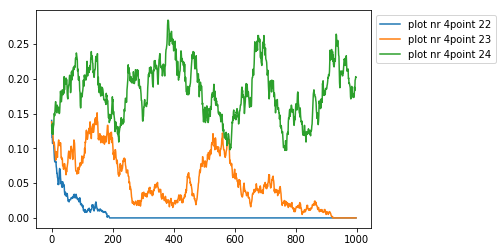

In [32]:
'''time series plot'''

for i in np.arange(363+22,363+25,1) :
    nr=(i)%121
    a = np.loadtxt("epid_time_series_ws.txt")[i,:]
    plt.plot(a,label='plot nr %i'%(int(i/121)+1)+"point %i"%nr)
    plt.legend(bbox_to_anchor=(1,1))
#     plt.axhline(y=0.6)
#     plt.axhline(y=0.4)

#     k = 1000
#     phi_star = sum(a[0,k-100:k])/100 #obtaining average phi_star of the last 100 time steps
#     print("phi_star=",phi_star)

In [21]:
'''averaging from time series'''

f = open("epid_phi_star_data_ws.txt","w+") 
k = 1000
# phi_star = sum(a[counter,k-100:k])/100 #obtaining average phi_star of the last 100 time steps
# print("phi_star=",phi_star)

counter = 0
for p in range(0,11):
    p = p*0.1
    print(p)
    for start in range(0,11):
        start = start*0.1
        for p_rew in range(0,11) :
            p_rew = p_rew*0.1
            a = np.loadtxt("epid_time_series_ws.txt")[counter,:]
            phi_star = np.average(a[k-100:k])
            f.write("%f\t%f\t%f\t%f\n" % (p,start,p_rew,phi_star))
            f.flush()
            counter = counter + 1
print(counter)

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
1331


AxesSubplot(0.125,0.71587;0.227941x0.16413)
AxesSubplot(0.398529,0.71587;0.227941x0.16413)
AxesSubplot(0.672059,0.71587;0.227941x0.16413)
AxesSubplot(0.125,0.518913;0.227941x0.16413)
AxesSubplot(0.398529,0.518913;0.227941x0.16413)
AxesSubplot(0.672059,0.518913;0.227941x0.16413)
AxesSubplot(0.125,0.321957;0.227941x0.16413)
AxesSubplot(0.398529,0.321957;0.227941x0.16413)
AxesSubplot(0.672059,0.321957;0.227941x0.16413)
AxesSubplot(0.125,0.125;0.227941x0.16413)
AxesSubplot(0.398529,0.125;0.227941x0.16413)
AxesSubplot(0.672059,0.125;0.227941x0.16413)


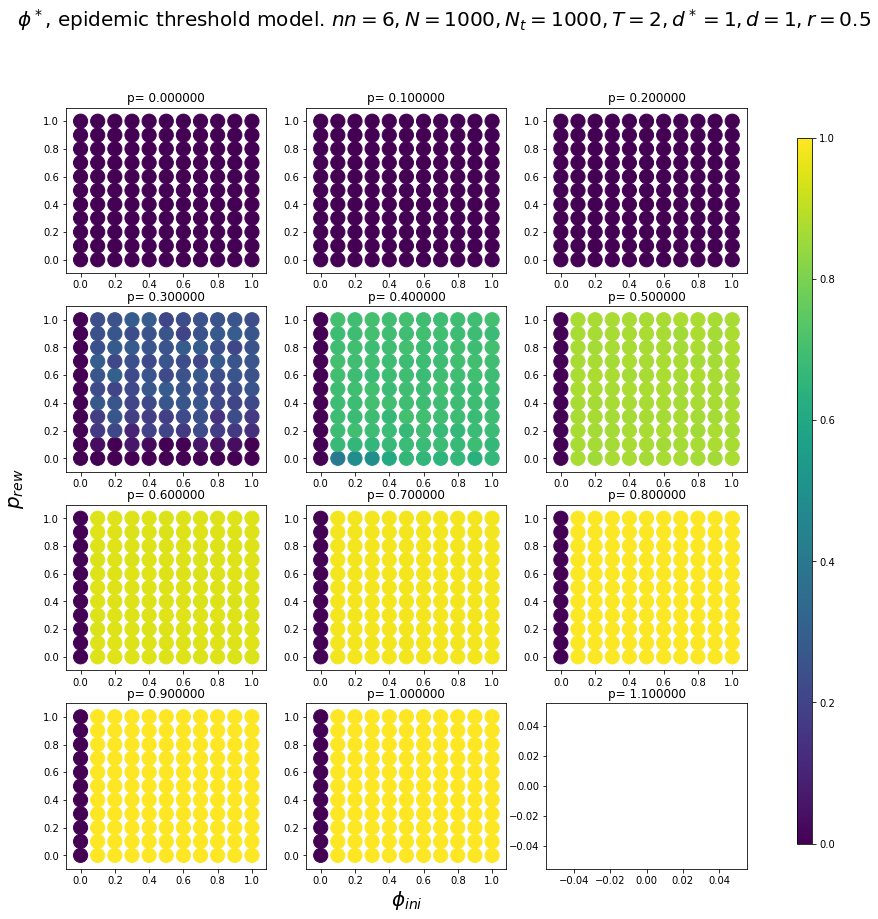

In [44]:
'''colourmap plot again'''

# a = np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,0]
# b =  np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,1]
# c =  np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,2]
d = np.loadtxt("epid_phi_star_data_ws.txt")[:,3]


counter = 0
l = 0
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(14,14))
i = 0
for row in ax:
    k = 0
    for col in row:
        print(col)
        ax[i, k].set_title('p= %f' %l)
        l = l + 0.1
        j = 121*counter
        im = col.scatter(np.loadtxt("epid_phi_star_data_ws.txt")[j:121*(counter+1),1],np.loadtxt("epid_phi_star_data_ws.txt")[j:121*(counter+1),2], c=np.loadtxt("epid_phi_star_data_ws.txt")[j:121*(counter+1),3],s=200,vmin=0, vmax=1)
        k = k + 1
        counter = counter + 1
    i = i + 1

nax = fig.add_subplot(111, frame_on = False)
nax.set_xticks([])
nax.set_yticks([])
fig.suptitle(r'$\phi^*$, epidemic threshold model. $nn=6,N=1000,N_t=1000,T=2,d^*=1,d=1,r=0.5$',fontsize = 20)
nax.set_xlabel(r'$\phi_{ini}$', fontsize = 20, labelpad=20)
nax.set_ylabel(r'$p_{rew}$', fontsize = 20, labelpad=40)
fig.subplots_adjust(right=0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.savefig("epid_params.svg", format="svg")


In [2]:
a = np.loadtxt("epid_time_series_ws.txt")[0,:]

df = pd.DataFrame(a,index=range(0,999))
# a = np.loadtxt("critic_time_series_ws_winnie.txt")[120,:]
# df[2] = pd.DataFrame(a,index=range(0,1000))

for i in range(1,1321) :
    print(i)
    a = np.loadtxt("epid_time_series_ws.txt")[i,:]
    df[i] = pd.DataFrame(a,index=range(0,999))
df


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


,0,1,2,3,4,5,6,7,8,9,...,1311,1312,1313,1314,1315,1316,1317,1318,1319,1320
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.918,0.927,0.938,0.953,0.959,0.968,0.963,0.981,0.987,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.941,0.959,0.964,0.987,0.991,0.997,0.987,0.998,1.000,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.962,0.985,0.990,0.998,1.000,0.999,1.000,1.000,1.000,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.982,0.996,0.998,0.999,1.000,1.000,1.000,1.000,1.000,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.995,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.999,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.0


In [3]:
df.to_csv('df_epid_time_series.csv')

In [31]:
df = pd.read_csv('df_epid_time_series.csv')
df.iloc[:, [1321]]

,1320
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


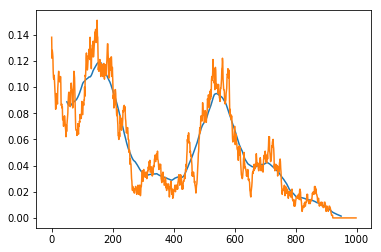

        386
387  0.0294
    386
0  True


In [14]:
point = 363+24

x = df.iloc[:, [point]]
# smooth = x.rolling(window=100,center=False).mean().shift(-199)
smooth = x.rolling(window=100,center=True).mean()
plt.plot(smooth)
a = np.loadtxt("epid_time_series_ws.txt")[point-1,:]
plt.plot(a)
plt.show()
print(smooth.iloc[[point], [0]])
# print(np.isnan(smooth.iloc[[0], [0]]))
print(pd.isnull(smooth.iloc[[0], [0]]))

In [19]:
time_reach_ss(1322,200,0.005,50)

IndexError: positional indexers are out-of-bounds

In [10]:
def time_reach_ss(point,lim,tol,window_size) :
    x = df.iloc[:, [point]]
    # smooth = x.rolling(window=100,center=False).mean().shift(-199)
    smooth = x.rolling(window=window_size,center=True).mean()
    count = 0
    b = np.loadtxt("epid_phi_star_data_ws.txt")[point-1,3]
    print('steady_state_phi_star=',b)
    for i in range(0,999) :
        if not(pd.isnull(smooth.iloc[[i], [0]]).bool()): 
#             print((smooth.iloc[[i], [0]]))
            j = i
            while (((smooth.iloc[[j], [0]]) < (tol+b)) & ((smooth.iloc[[j], [0]]) > (b-tol)) & (j<i+100)).bool() :
                count = count + 1
#                 print('count = ',count)
                j = j + 1
    #             if j == i + 100 : 
            if count >= lim :
                count = 0
                print('steady state reached at i = ',i)
                return i

In [11]:
#opening a file to store data
g = open("epid_ss_ws.txt","w+") 

point = 1
for p in range(0,11) :
    p = p*0.1
    for start in range(0,11) :
        start = start*0.1
        for p_rew in range(0,11) :
            p_rew = p_rew*0.1
            print('p=',p)
            print('start=',start)
            print('p_rew=',p_rew)
#             for point in range(484+77,484+77+11) :
            print('point=',point)
            tol = 0.005
            lim = 200
            window_size = 50
            i = time_reach_ss(point,lim,tol,window_size)
            if i is not None :
                g.write("%f\t%f\t%f\t%f\n" % (p,start,p_rew,i))
                g.flush()
                point = point + 1
            else :
#                 g.write("%f\t%f\t%f\t\n" % (p,start,p_rew))
#                 g.flush()
                point = point + 1

p= 0.0
start= 0.0
p_rew= 0.0
point= 1
steady_state_phi_star= 0.0
steady state reached at i =  26
p= 0.0
start= 0.0
p_rew= 0.1
point= 2
steady_state_phi_star= 0.0
steady state reached at i =  26
p= 0.0
start= 0.0
p_rew= 0.2
point= 3
steady_state_phi_star= 0.0
steady state reached at i =  26
p= 0.0
start= 0.0
p_rew= 0.30000000000000004
point= 4
steady_state_phi_star= 0.0
steady state reached at i =  26
p= 0.0
start= 0.0
p_rew= 0.4
point= 5
steady_state_phi_star= 0.0
steady state reached at i =  26
p= 0.0
start= 0.0
p_rew= 0.5
point= 6
steady_state_phi_star= 0.0
steady state reached at i =  26
p= 0.0
start= 0.0
p_rew= 0.6000000000000001
point= 7
steady_state_phi_star= 0.0
steady state reached at i =  26
p= 0.0
start= 0.0
p_rew= 0.7000000000000001
point= 8
steady_state_phi_star= 0.0
steady state reached at i =  26
p= 0.0
start= 0.0
p_rew= 0.8
point= 9
steady_state_phi_star= 0.0
steady state reached at i =  26
p= 0.0
start= 0.0
p_rew= 0.9
point= 10
steady_state_phi_star= 0.0
steady state re

steady_state_phi_star= 0.0
steady state reached at i =  28
p= 0.0
start= 0.7000000000000001
p_rew= 0.2
point= 80
steady_state_phi_star= 0.0
steady state reached at i =  28
p= 0.0
start= 0.7000000000000001
p_rew= 0.30000000000000004
point= 81
steady_state_phi_star= 0.0
steady state reached at i =  28
p= 0.0
start= 0.7000000000000001
p_rew= 0.4
point= 82
steady_state_phi_star= 0.0
steady state reached at i =  28
p= 0.0
start= 0.7000000000000001
p_rew= 0.5
point= 83
steady_state_phi_star= 0.0
steady state reached at i =  28
p= 0.0
start= 0.7000000000000001
p_rew= 0.6000000000000001
point= 84
steady_state_phi_star= 0.0
steady state reached at i =  28
p= 0.0
start= 0.7000000000000001
p_rew= 0.7000000000000001
point= 85
steady_state_phi_star= 0.0
steady state reached at i =  28
p= 0.0
start= 0.7000000000000001
p_rew= 0.8
point= 86
steady_state_phi_star= 0.0
steady state reached at i =  28
p= 0.0
start= 0.7000000000000001
p_rew= 0.9
point= 87
steady_state_phi_star= 0.0
steady state reached at

steady state reached at i =  30
p= 0.1
start= 0.30000000000000004
p_rew= 0.30000000000000004
point= 158
steady_state_phi_star= 0.0
steady state reached at i =  30
p= 0.1
start= 0.30000000000000004
p_rew= 0.4
point= 159
steady_state_phi_star= 0.0
steady state reached at i =  29
p= 0.1
start= 0.30000000000000004
p_rew= 0.5
point= 160
steady_state_phi_star= 0.0
steady state reached at i =  29
p= 0.1
start= 0.30000000000000004
p_rew= 0.6000000000000001
point= 161
steady_state_phi_star= 0.0
steady state reached at i =  29
p= 0.1
start= 0.30000000000000004
p_rew= 0.7000000000000001
point= 162
steady_state_phi_star= 0.0
steady state reached at i =  29
p= 0.1
start= 0.30000000000000004
p_rew= 0.8
point= 163
steady_state_phi_star= 0.0
steady state reached at i =  30
p= 0.1
start= 0.30000000000000004
p_rew= 0.9
point= 164
steady_state_phi_star= 0.0
steady state reached at i =  29
p= 0.1
start= 0.30000000000000004
p_rew= 1.0
point= 165
steady_state_phi_star= 0.0
steady state reached at i =  30
p=

steady state reached at i =  35
p= 0.1
start= 1.0
p_rew= 0.1
point= 233
steady_state_phi_star= 0.0
steady state reached at i =  32
p= 0.1
start= 1.0
p_rew= 0.2
point= 234
steady_state_phi_star= 0.0
steady state reached at i =  35
p= 0.1
start= 1.0
p_rew= 0.30000000000000004
point= 235
steady_state_phi_star= 0.0
steady state reached at i =  34
p= 0.1
start= 1.0
p_rew= 0.4
point= 236
steady_state_phi_star= 0.0
steady state reached at i =  34
p= 0.1
start= 1.0
p_rew= 0.5
point= 237
steady_state_phi_star= 0.0
steady state reached at i =  33
p= 0.1
start= 1.0
p_rew= 0.6000000000000001
point= 238
steady_state_phi_star= 0.0
steady state reached at i =  32
p= 0.1
start= 1.0
p_rew= 0.7000000000000001
point= 239
steady_state_phi_star= 0.0
steady state reached at i =  34
p= 0.1
start= 1.0
p_rew= 0.8
point= 240
steady_state_phi_star= 0.0
steady state reached at i =  33
p= 0.1
start= 1.0
p_rew= 0.9
point= 241
steady_state_phi_star= 0.0
steady state reached at i =  34
p= 0.1
start= 1.0
p_rew= 1.0
po

steady state reached at i =  48
p= 0.2
start= 0.6000000000000001
p_rew= 0.2
point= 311
steady_state_phi_star= 0.0
steady state reached at i =  48
p= 0.2
start= 0.6000000000000001
p_rew= 0.30000000000000004
point= 312
steady_state_phi_star= 0.0
steady state reached at i =  59
p= 0.2
start= 0.6000000000000001
p_rew= 0.4
point= 313
steady_state_phi_star= 0.0
steady state reached at i =  58
p= 0.2
start= 0.6000000000000001
p_rew= 0.5
point= 314
steady_state_phi_star= 0.0
steady state reached at i =  57
p= 0.2
start= 0.6000000000000001
p_rew= 0.6000000000000001
point= 315
steady_state_phi_star= 0.0
steady state reached at i =  64
p= 0.2
start= 0.6000000000000001
p_rew= 0.7000000000000001
point= 316
steady_state_phi_star= 0.0
steady state reached at i =  48
p= 0.2
start= 0.6000000000000001
p_rew= 0.8
point= 317
steady_state_phi_star= 0.0
steady state reached at i =  53
p= 0.2
start= 0.6000000000000001
p_rew= 0.9
point= 318
steady_state_phi_star= 0.0
steady state reached at i =  46
p= 0.2
sta

steady_state_phi_star= 0.24402
steady state reached at i =  176
p= 0.30000000000000004
start= 0.1
p_rew= 1.0
point= 385
steady_state_phi_star= 0.241879
steady state reached at i =  621
p= 0.30000000000000004
start= 0.2
p_rew= 0.0
point= 386
steady_state_phi_star= 0.0
steady state reached at i =  183
p= 0.30000000000000004
start= 0.2
p_rew= 0.1
point= 387
steady_state_phi_star= 0.001313
steady state reached at i =  909
p= 0.30000000000000004
start= 0.2
p_rew= 0.2
point= 388
steady_state_phi_star= 0.211556
steady state reached at i =  130
p= 0.30000000000000004
start= 0.2
p_rew= 0.30000000000000004
point= 389
steady_state_phi_star= 0.267404
p= 0.30000000000000004
start= 0.2
p_rew= 0.4
point= 390
steady_state_phi_star= 0.259313
steady state reached at i =  357
p= 0.30000000000000004
start= 0.2
p_rew= 0.5
point= 391
steady_state_phi_star= 0.199596
steady state reached at i =  836
p= 0.30000000000000004
start= 0.2
p_rew= 0.6000000000000001
point= 392
steady_state_phi_star= 0.30404
p= 0.3000

steady state reached at i =  188
p= 0.30000000000000004
start= 0.7000000000000001
p_rew= 0.8
point= 449
steady_state_phi_star= 0.285596
steady state reached at i =  829
p= 0.30000000000000004
start= 0.7000000000000001
p_rew= 0.9
point= 450
steady_state_phi_star= 0.255202
steady state reached at i =  199
p= 0.30000000000000004
start= 0.7000000000000001
p_rew= 1.0
point= 451
steady_state_phi_star= 0.253071
steady state reached at i =  589
p= 0.30000000000000004
start= 0.8
p_rew= 0.0
point= 452
steady_state_phi_star= 0.0
steady state reached at i =  177
p= 0.30000000000000004
start= 0.8
p_rew= 0.1
point= 453
steady_state_phi_star= 0.041394
steady state reached at i =  625
p= 0.30000000000000004
start= 0.8
p_rew= 0.2
point= 454
steady_state_phi_star= 0.180505
steady state reached at i =  119
p= 0.30000000000000004
start= 0.8
p_rew= 0.30000000000000004
point= 455
steady_state_phi_star= 0.148343
steady state reached at i =  957
p= 0.30000000000000004
start= 0.8
p_rew= 0.4
point= 456
steady_s

steady state reached at i =  314
p= 0.4
start= 0.30000000000000004
p_rew= 0.2
point= 520
steady_state_phi_star= 0.690919
steady state reached at i =  297
p= 0.4
start= 0.30000000000000004
p_rew= 0.30000000000000004
point= 521
steady_state_phi_star= 0.687566
steady state reached at i =  223
p= 0.4
start= 0.30000000000000004
p_rew= 0.4
point= 522
steady_state_phi_star= 0.699374
steady state reached at i =  194
p= 0.4
start= 0.30000000000000004
p_rew= 0.5
point= 523
steady_state_phi_star= 0.70096
steady state reached at i =  256
p= 0.4
start= 0.30000000000000004
p_rew= 0.6000000000000001
point= 524
steady_state_phi_star= 0.680657
steady state reached at i =  76
p= 0.4
start= 0.30000000000000004
p_rew= 0.7000000000000001
point= 525
steady_state_phi_star= 0.697232
steady state reached at i =  63
p= 0.4
start= 0.30000000000000004
p_rew= 0.8
point= 526
steady_state_phi_star= 0.686222
steady state reached at i =  102
p= 0.4
start= 0.30000000000000004
p_rew= 0.9
point= 527
steady_state_phi_star

steady state reached at i =  55
p= 0.4
start= 0.9
p_rew= 0.8
point= 592
steady_state_phi_star= 0.689838
steady state reached at i =  61
p= 0.4
start= 0.9
p_rew= 0.9
point= 593
steady_state_phi_star= 0.689717
steady state reached at i =  29
p= 0.4
start= 0.9
p_rew= 1.0
point= 594
steady_state_phi_star= 0.693545
steady state reached at i =  36
p= 0.4
start= 1.0
p_rew= 0.0
point= 595
steady_state_phi_star= 0.667545
steady state reached at i =  537
p= 0.4
start= 1.0
p_rew= 0.1
point= 596
steady_state_phi_star= 0.666818
steady state reached at i =  166
p= 0.4
start= 1.0
p_rew= 0.2
point= 597
steady_state_phi_star= 0.682939
steady state reached at i =  35
p= 0.4
start= 1.0
p_rew= 0.30000000000000004
point= 598
steady_state_phi_star= 0.685465
steady state reached at i =  101
p= 0.4
start= 1.0
p_rew= 0.4
point= 599
steady_state_phi_star= 0.679222
steady state reached at i =  52
p= 0.4
start= 1.0
p_rew= 0.5
point= 600
steady_state_phi_star= 0.687202
steady state reached at i =  40
p= 0.4
start=

steady state reached at i =  36
p= 0.5
start= 0.5
p_rew= 0.6000000000000001
point= 667
steady_state_phi_star= 0.869869
steady state reached at i =  34
p= 0.5
start= 0.5
p_rew= 0.7000000000000001
point= 668
steady_state_phi_star= 0.869576
steady state reached at i =  40
p= 0.5
start= 0.5
p_rew= 0.8
point= 669
steady_state_phi_star= 0.869758
steady state reached at i =  32
p= 0.5
start= 0.5
p_rew= 0.9
point= 670
steady_state_phi_star= 0.871667
steady state reached at i =  106
p= 0.5
start= 0.5
p_rew= 1.0
point= 671
steady_state_phi_star= 0.869101
steady state reached at i =  44
p= 0.5
start= 0.6000000000000001
p_rew= 0.0
point= 672
steady_state_phi_star= 0.870919
steady state reached at i =  386
p= 0.5
start= 0.6000000000000001
p_rew= 0.1
point= 673
steady_state_phi_star= 0.859636
steady state reached at i =  43
p= 0.5
start= 0.6000000000000001
p_rew= 0.2
point= 674
steady_state_phi_star= 0.871667
steady state reached at i =  43
p= 0.5
start= 0.6000000000000001
p_rew= 0.30000000000000004

steady state reached at i =  635
p= 0.6000000000000001
start= 0.1
p_rew= 0.1
point= 739
steady_state_phi_star= 0.947556
steady state reached at i =  52
p= 0.6000000000000001
start= 0.1
p_rew= 0.2
point= 740
steady_state_phi_star= 0.944808
steady state reached at i =  43
p= 0.6000000000000001
start= 0.1
p_rew= 0.30000000000000004
point= 741
steady_state_phi_star= 0.947687
steady state reached at i =  39
p= 0.6000000000000001
start= 0.1
p_rew= 0.4
point= 742
steady_state_phi_star= 0.947939
steady state reached at i =  39
p= 0.6000000000000001
start= 0.1
p_rew= 0.5
point= 743
steady_state_phi_star= 0.94999
steady state reached at i =  43
p= 0.6000000000000001
start= 0.1
p_rew= 0.6000000000000001
point= 744
steady_state_phi_star= 0.948909
steady state reached at i =  39
p= 0.6000000000000001
start= 0.1
p_rew= 0.7000000000000001
point= 745
steady_state_phi_star= 0.944717
steady state reached at i =  37
p= 0.6000000000000001
start= 0.1
p_rew= 0.8
point= 746
steady_state_phi_star= 0.948364
st

steady state reached at i =  30
p= 0.6000000000000001
start= 0.6000000000000001
p_rew= 1.0
point= 803
steady_state_phi_star= 0.945505
steady state reached at i =  29
p= 0.6000000000000001
start= 0.7000000000000001
p_rew= 0.0
point= 804
steady_state_phi_star= 0.944556
steady state reached at i =  212
p= 0.6000000000000001
start= 0.7000000000000001
p_rew= 0.1
point= 805
steady_state_phi_star= 0.94697
steady state reached at i =  39
p= 0.6000000000000001
start= 0.7000000000000001
p_rew= 0.2
point= 806
steady_state_phi_star= 0.950566
steady state reached at i =  34
p= 0.6000000000000001
start= 0.7000000000000001
p_rew= 0.30000000000000004
point= 807
steady_state_phi_star= 0.946121
steady state reached at i =  33
p= 0.6000000000000001
start= 0.7000000000000001
p_rew= 0.4
point= 808
steady_state_phi_star= 0.944869
steady state reached at i =  48
p= 0.6000000000000001
start= 0.7000000000000001
p_rew= 0.5
point= 809
steady_state_phi_star= 0.947717
steady state reached at i =  30
p= 0.600000000

steady state reached at i =  36
p= 0.7000000000000001
start= 0.1
p_rew= 1.0
point= 869
steady_state_phi_star= 0.981838
steady state reached at i =  34
p= 0.7000000000000001
start= 0.2
p_rew= 0.0
point= 870
steady_state_phi_star= 0.981808
steady state reached at i =  503
p= 0.7000000000000001
start= 0.2
p_rew= 0.1
point= 871
steady_state_phi_star= 0.981212
steady state reached at i =  41
p= 0.7000000000000001
start= 0.2
p_rew= 0.2
point= 872
steady_state_phi_star= 0.981051
steady state reached at i =  37
p= 0.7000000000000001
start= 0.2
p_rew= 0.30000000000000004
point= 873
steady_state_phi_star= 0.981495
steady state reached at i =  36
p= 0.7000000000000001
start= 0.2
p_rew= 0.4
point= 874
steady_state_phi_star= 0.982253
steady state reached at i =  34
p= 0.7000000000000001
start= 0.2
p_rew= 0.5
point= 875
steady_state_phi_star= 0.981485
steady state reached at i =  34
p= 0.7000000000000001
start= 0.2
p_rew= 0.6000000000000001
point= 876
steady_state_phi_star= 0.982333
steady state rea

steady state reached at i =  29
p= 0.7000000000000001
start= 0.7000000000000001
p_rew= 0.7000000000000001
point= 932
steady_state_phi_star= 0.981889
steady state reached at i =  28
p= 0.7000000000000001
start= 0.7000000000000001
p_rew= 0.8
point= 933
steady_state_phi_star= 0.980818
steady state reached at i =  28
p= 0.7000000000000001
start= 0.7000000000000001
p_rew= 0.9
point= 934
steady_state_phi_star= 0.981212
steady state reached at i =  28
p= 0.7000000000000001
start= 0.7000000000000001
p_rew= 1.0
point= 935
steady_state_phi_star= 0.980818
steady state reached at i =  26
p= 0.7000000000000001
start= 0.8
p_rew= 0.0
point= 936
steady_state_phi_star= 0.980535
steady state reached at i =  131
p= 0.7000000000000001
start= 0.8
p_rew= 0.1
point= 937
steady_state_phi_star= 0.98204
steady state reached at i =  33
p= 0.7000000000000001
start= 0.8
p_rew= 0.2
point= 938
steady_state_phi_star= 0.98102
steady state reached at i =  30
p= 0.7000000000000001
start= 0.8
p_rew= 0.30000000000000004
p

steady state reached at i =  353
p= 0.8
start= 0.30000000000000004
p_rew= 0.1
point= 1003
steady_state_phi_star= 0.995343
steady state reached at i =  38
p= 0.8
start= 0.30000000000000004
p_rew= 0.2
point= 1004
steady_state_phi_star= 0.995071
steady state reached at i =  34
p= 0.8
start= 0.30000000000000004
p_rew= 0.30000000000000004
point= 1005
steady_state_phi_star= 0.995192
steady state reached at i =  33
p= 0.8
start= 0.30000000000000004
p_rew= 0.4
point= 1006
steady_state_phi_star= 0.995677
steady state reached at i =  32
p= 0.8
start= 0.30000000000000004
p_rew= 0.5
point= 1007
steady_state_phi_star= 0.994909
steady state reached at i =  31
p= 0.8
start= 0.30000000000000004
p_rew= 0.6000000000000001
point= 1008
steady_state_phi_star= 0.995808
steady state reached at i =  30
p= 0.8
start= 0.30000000000000004
p_rew= 0.7000000000000001
point= 1009
steady_state_phi_star= 0.995808
steady state reached at i =  30
p= 0.8
start= 0.30000000000000004
p_rew= 0.8
point= 1010
steady_state_phi_

steady_state_phi_star= 0.995071
steady state reached at i =  26
p= 0.8
start= 0.9
p_rew= 0.6000000000000001
point= 1074
steady_state_phi_star= 0.995556
steady state reached at i =  26
p= 0.8
start= 0.9
p_rew= 0.7000000000000001
point= 1075
steady_state_phi_star= 0.995909
steady state reached at i =  26
p= 0.8
start= 0.9
p_rew= 0.8
point= 1076
steady_state_phi_star= 0.994859
steady state reached at i =  26
p= 0.8
start= 0.9
p_rew= 0.9
point= 1077
steady_state_phi_star= 0.995
steady state reached at i =  26
p= 0.8
start= 0.9
p_rew= 1.0
point= 1078
steady_state_phi_star= 0.994909
steady state reached at i =  26
p= 0.8
start= 1.0
p_rew= 0.0
point= 1079
steady_state_phi_star= 0.995465
steady state reached at i =  26
p= 0.8
start= 1.0
p_rew= 0.1
point= 1080
steady_state_phi_star= 0.995384
steady state reached at i =  26
p= 0.8
start= 1.0
p_rew= 0.2
point= 1081
steady_state_phi_star= 0.995737
steady state reached at i =  26
p= 0.8
start= 1.0
p_rew= 0.30000000000000004
point= 1082
steady_state

steady state reached at i =  31
p= 0.9
start= 0.5
p_rew= 0.30000000000000004
point= 1148
steady_state_phi_star= 0.999556
steady state reached at i =  30
p= 0.9
start= 0.5
p_rew= 0.4
point= 1149
steady_state_phi_star= 0.999485
steady state reached at i =  29
p= 0.9
start= 0.5
p_rew= 0.5
point= 1150
steady_state_phi_star= 0.999475
steady state reached at i =  29
p= 0.9
start= 0.5
p_rew= 0.6000000000000001
point= 1151
steady_state_phi_star= 0.999545
steady state reached at i =  29
p= 0.9
start= 0.5
p_rew= 0.7000000000000001
point= 1152
steady_state_phi_star= 0.999485
steady state reached at i =  28
p= 0.9
start= 0.5
p_rew= 0.8
point= 1153
steady_state_phi_star= 0.999566
steady state reached at i =  28
p= 0.9
start= 0.5
p_rew= 0.9
point= 1154
steady_state_phi_star= 0.999495
steady state reached at i =  27
p= 0.9
start= 0.5
p_rew= 1.0
point= 1155
steady_state_phi_star= 0.999404
steady state reached at i =  28
p= 0.9
start= 0.6000000000000001
p_rew= 0.0
point= 1156
steady_state_phi_star= 0.9

steady state reached at i =  26
p= 1.0
start= 0.0
p_rew= 0.9
point= 1220
steady_state_phi_star= 0.0
steady state reached at i =  26
p= 1.0
start= 0.0
p_rew= 1.0
point= 1221
steady_state_phi_star= 0.0
steady state reached at i =  26
p= 1.0
start= 0.1
p_rew= 0.0
point= 1222
steady_state_phi_star= 1.0
steady state reached at i =  374
p= 1.0
start= 0.1
p_rew= 0.1
point= 1223
steady_state_phi_star= 1.0
steady state reached at i =  39
p= 1.0
start= 0.1
p_rew= 0.2
point= 1224
steady_state_phi_star= 1.0
steady state reached at i =  35
p= 1.0
start= 0.1
p_rew= 0.30000000000000004
point= 1225
steady_state_phi_star= 1.0
steady state reached at i =  33
p= 1.0
start= 0.1
p_rew= 0.4
point= 1226
steady_state_phi_star= 1.0
steady state reached at i =  32
p= 1.0
start= 0.1
p_rew= 0.5
point= 1227
steady_state_phi_star= 1.0
steady state reached at i =  32
p= 1.0
start= 0.1
p_rew= 0.6000000000000001
point= 1228
steady_state_phi_star= 1.0
steady state reached at i =  31
p= 1.0
start= 0.1
p_rew= 0.700000000

steady state reached at i =  27
p= 1.0
start= 0.7000000000000001
p_rew= 0.7000000000000001
point= 1295
steady_state_phi_star= 1.0
steady state reached at i =  26
p= 1.0
start= 0.7000000000000001
p_rew= 0.8
point= 1296
steady_state_phi_star= 1.0
steady state reached at i =  26
p= 1.0
start= 0.7000000000000001
p_rew= 0.9
point= 1297
steady_state_phi_star= 1.0
steady state reached at i =  26
p= 1.0
start= 0.7000000000000001
p_rew= 1.0
point= 1298
steady_state_phi_star= 1.0
steady state reached at i =  26
p= 1.0
start= 0.8
p_rew= 0.0
point= 1299
steady_state_phi_star= 1.0
steady state reached at i =  102
p= 1.0
start= 0.8
p_rew= 0.1
point= 1300
steady_state_phi_star= 1.0
steady state reached at i =  29
p= 1.0
start= 0.8
p_rew= 0.2
point= 1301
steady_state_phi_star= 1.0
steady state reached at i =  28
p= 1.0
start= 0.8
p_rew= 0.30000000000000004
point= 1302
steady_state_phi_star= 1.0
steady state reached at i =  27
p= 1.0
start= 0.8
p_rew= 0.4
point= 1303
steady_state_phi_star= 1.0
steady s

IndexError: positional indexers are out-of-bounds

1.0
1314
AxesSubplot(0.125,0.71587;0.227941x0.16413)
0 0
0.0
AxesSubplot(0.398529,0.71587;0.227941x0.16413)
121 0.1
0.1
AxesSubplot(0.672059,0.71587;0.227941x0.16413)
242 0.2
0.2
AxesSubplot(0.125,0.518913;0.227941x0.16413)
363 0.3
0.3
AxesSubplot(0.398529,0.518913;0.227941x0.16413)
479 0.4
0.4
AxesSubplot(0.672059,0.518913;0.227941x0.16413)
598 0.5
0.5
AxesSubplot(0.125,0.321957;0.227941x0.16413)
719 0.6
0.6
AxesSubplot(0.398529,0.321957;0.227941x0.16413)
840 0.7
0.7
AxesSubplot(0.672059,0.321957;0.227941x0.16413)
961 0.8
0.8
AxesSubplot(0.125,0.125;0.227941x0.16413)
1082 0.9
0.9
AxesSubplot(0.398529,0.125;0.227941x0.16413)
1203 1.0
1.0
AxesSubplot(0.672059,0.125;0.227941x0.16413)
1313 1.1
1.0


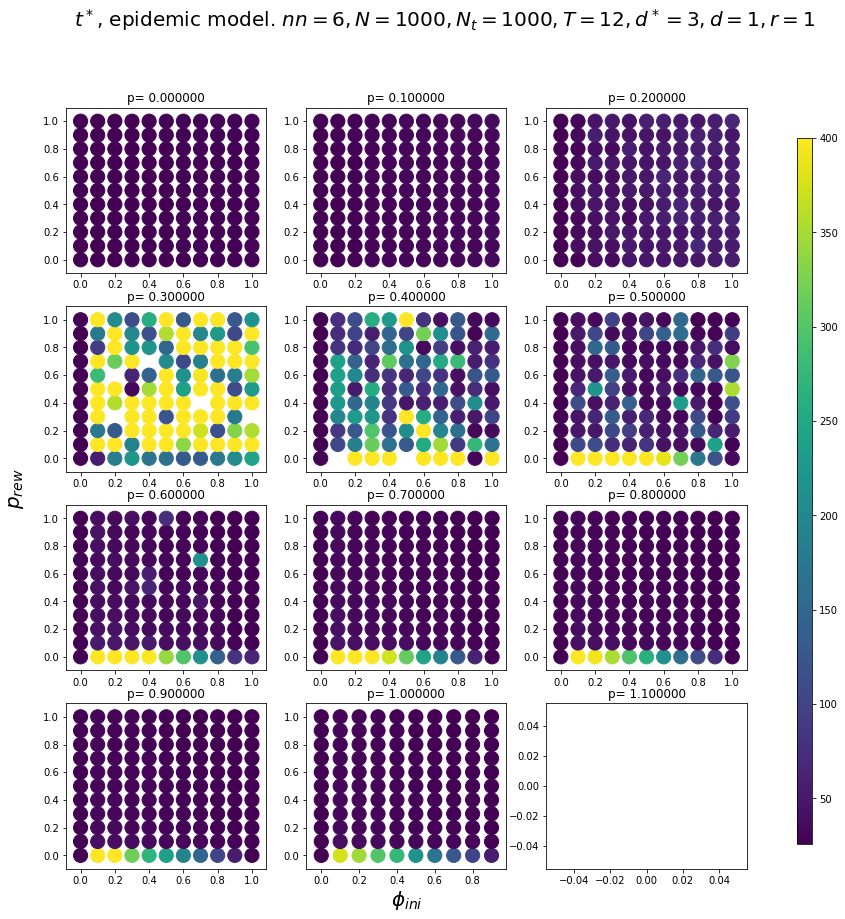

In [18]:
'''colour plot again :P'''
# a = np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,0]
# b =  np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,1]
# c =  np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,2]
d = np.loadtxt("epid_ss_ws.txt")[:,3]
print(np.loadtxt("epid_ss_ws.txt")[1238,0])
print(len(d))
count = 0
plot_count = 1
j = 0
l = 0
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(14,14))
i = 0
for row in ax:
    k = 0
    for col in row:
        print(col)
        ax[i, k].set_title('p= %f' %l)
#         count = count + plot_count-1
        plot_count = 0
        print(count,round(l,2))
        print(np.loadtxt("epid_ss_ws.txt")[count,0])
        while (count < len(d)-1) and np.loadtxt("epid_ss_ws.txt")[count,0] == round(l,2)  :
            plot_count = plot_count + 1
            count = count + 1
#             print(count)
        end =  count
#         count = plot_count-1
        im = col.scatter(np.loadtxt("epid_ss_ws.txt")[j:end,1],np.loadtxt("epid_ss_ws.txt")[j:end,2], c=np.loadtxt("epid_ss_ws.txt")[j:end,3],s=200,vmin=26, vmax=400)
        j = end
        l = l + 0.1
        k = k + 1
    i = i + 1

nax = fig.add_subplot(111, frame_on = False)
nax.set_xticks([])
nax.set_yticks([])
fig.suptitle(r'$t^*$, epidemic model. $nn=6,N=1000,N_t=1000,T=12,d^*=3,d=1,r=1$',fontsize = 20)
nax.set_xlabel(r'$\phi_{ini}$', fontsize = 20, labelpad=20)
nax.set_ylabel(r'$p_{rew}$', fontsize = 20, labelpad=40)
fig.subplots_adjust(right=0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.savefig("epid_steady_state.svg", format="svg")